In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
import acquire
import prepare
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
# importing my personal wrangle module
import wrangle
import explore

In [2]:
# Acquiring the data using the above module
zillow_sql_query = wrangle.get_zillow_data()
# PLEASE THINK ABOUT ADDING A ZILLOW_COPY TO WORK WITH FROM HERE, THEREBY AVOIDING FUTURE SQL QUERIES
# Code below will have to be updated accordingly.  
zillow = zillow_sql_query.copy()

In [3]:
zillow.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [4]:
# Using my wrangle module to clean and prep the data. NaNs are dropped; so are outliers. 
# In the end, I added an 'age' column and deleted the yearbuilt column (which was more like a categorical variable)
# No outliers were removed from year built, age, or fips
zillow = wrangle.clean_and_prep_data(zillow)

Consider dropping yearbuilt as a column--this is a categorical and is closely related to age, which will be the feature we use instead.

Consider the k value used removing outliers--there are a couple features that may be better with a different value.  I'm thinking of the 1 bedroom houses, for example.

In [5]:
zillow.head()

,bedrooms,bathrooms,sq_ft,tax_amount,county,age
6,3.0,4.0,1620.0,10244.94,LA,10
7,3.0,2.0,2077.0,7924.68,LA,95
18,3.0,1.0,1244.0,2532.88,LA,71
19,3.0,2.0,1300.0,3110.99,LA,71
20,3.0,2.0,1222.0,3870.25,LA,70


In [6]:
zillow.shape

(1854286, 6)

In [7]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1854286 entries, 6 to 2152862
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   sq_ft       float64
 3   tax_amount  float64
 4   county      object 
 5   age         int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 99.0+ MB


In [8]:
# checking for null values
zillow.isnull().sum()

bedrooms      0
bathrooms     0
sq_ft         0
tax_amount    0
county        0
age           0
dtype: int64

In [9]:
# This is a for loop that is checking every column for any white space. there isn't any
# also the NaNs, actually. gone now.
cols = ['bedrooms', 'bathrooms', 'sq_ft', 'tax_amount', 'county','age']
for col in cols:
    print(zillow[col].value_counts(dropna=False,ascending=True))

5.0     89402
2.0    320442
4.0    539616
3.0    904826
Name: bedrooms, dtype: int64
1.75         3
3.50     12347
1.50     30713
4.00     31936
2.50    132322
3.00    351864
1.00    385677
2.00    909424
Name: bathrooms, dtype: int64
240.0        1
462.0        1
475.0        1
457.0        1
430.0        1
          ... 
1440.0    3617
1400.0    3776
1120.0    4286
1080.0    4313
1200.0    5091
Name: sq_ft, Length: 3013, dtype: int64
1451.43      1
2883.43      1
1737.88      1
6793.34      1
3041.35      1
          ... 
388.18      36
49.18       45
343.52      65
344.18      71
345.72     164
Name: tax_amount, Length: 710127, dtype: int64
Ventura     144730
Orange      468237
LA         1241319
Name: county, dtype: int64
220        1
142        1
147        1
159        1
144        1
188        1
166        1
198        1
214        1
145        2
143        2
156        2
151        2
209        2
140        3
139        6
138        6
146        7
137        8
130       24
132 

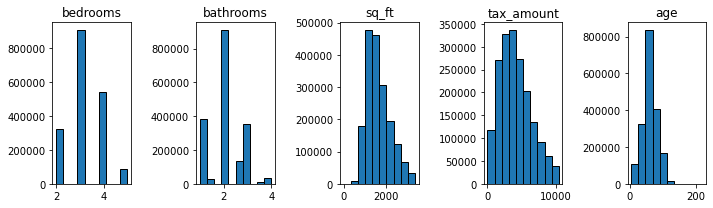

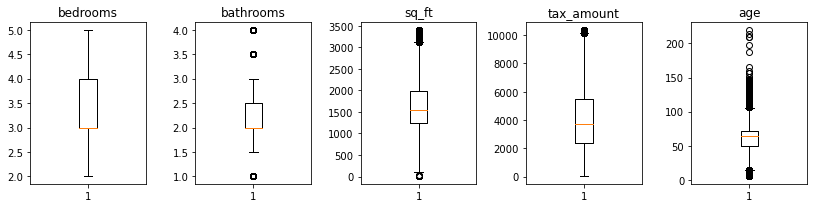

In [10]:
# Here, we create a for loop that makes a histogram for every column. This is the start of my univariate analysis

plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms', 'bathrooms','sq_ft','tax_amount', 'age']
# Note the enumerate code, which is functioning to make a counter for use in successive plots.

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,8, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    zillow[col].hist(bins=10, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)
    
    plt.tight_layout()
    
,

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,7, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    plt.boxplot(zillow[col])
    
    # Hide gridlines.
    plt.grid(False)
    
    plt.tight_layout()

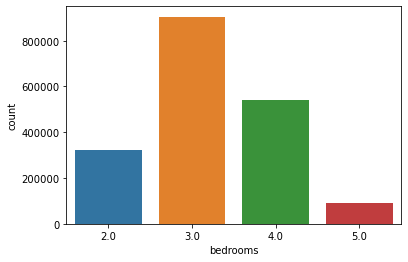

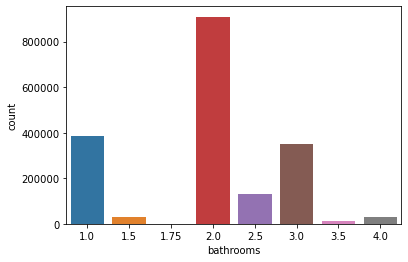

In [11]:
disc_vars = ['bedrooms','bathrooms']
for var in disc_vars:
    plt.figure()
    sns.countplot(x=var,data=zillow)

In [12]:
# Describe was displaying with scientific notation, so I rounded to 2 places.  
round(zillow.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
bedrooms,1854286.0,3.21,0.78,2.00,3.00,3.00,4.00,5.00
bathrooms,1854286.0,2.05,0.71,1.00,2.00,2.00,2.50,4.00
sq_ft,1854286.0,1653.71,564.43,1.00,1231.00,1548.00,1988.00,3408.00
tax_amount,1854286.0,4069.36,2242.13,16.48,2366.68,3747.14,5487.42,10377.04
age,1854286.0,61.56,20.55,5.00,49.00,64.00,72.00,220.00


### Notice the minimum bedrooms is 2.  I'm sure there were some useful one bedrooms before I removed the outliers.
### The minimum of 1 square foot isn't correct and should be addressed after arriving at MVP.  However, see the problems i was having figuring that out below.  moving on 
### These are homes around in Los Angeles, Ventura, and Orange County, CA

## Next steps: encode columns and split
### Encode the following:
- ['bedroomcnt','bathroomcnt','fips'] .... on second thought, only encode fips
- I will not use the yearbuilt in the final analysis, and instead use age, which is almost the same thing for my purposes.

In [13]:
zillow.sq_ft.sort_values()[zillow.sq_ft < 200]

1359288      1.0
2017745      1.0
58438        1.0
1686621      2.0
1428481      3.0
122963       3.0
1963976      3.0
584383       3.0
1219821     32.0
2002543    102.0
356552     120.0
469858     127.0
639525     132.0
2028617    152.0
2006838    152.0
938420     164.0
221296     164.0
1766110    169.0
538894     169.0
1852153    169.0
1034173    169.0
86579      169.0
1938125    169.0
926570     169.0
1981128    169.0
711205     169.0
754110     169.0
409547     169.0
76087      170.0
1260363    170.0
972869     173.0
987097     179.0
1447247    192.0
Name: sq_ft, dtype: float64

In [14]:
zillow.iloc[58438]

bedrooms          4.0
bathrooms         1.0
sq_ft          2200.0
tax_amount    4424.22
county             LA
age                38
Name: 67996, dtype: object

In [15]:
encoded = wrangle.encode_zillow(zillow)
encoded.head()

,bedrooms,bathrooms,sq_ft,tax_amount,county,age,LA,Orange,Ventura
6,3.0,4.0,1620.0,10244.94,LA,10,1,0,0
7,3.0,2.0,2077.0,7924.68,LA,95,1,0,0
18,3.0,1.0,1244.0,2532.88,LA,71,1,0,0
19,3.0,2.0,1300.0,3110.99,LA,71,1,0,0
20,3.0,2.0,1222.0,3870.25,LA,70,1,0,0


# SPLITTING

In [16]:
train, validate, test,X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_zillow(encoded)
train.shape, validate.shape, test.shape,X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((1038399, 9),
 (445029, 9),
 (370858, 9),
 (1038399, 8),
 (1038399, 1),
 (445029, 8),
 (445029, 1),
 (370858, 8),
 (370858, 1))

# DATA EXPLORATION--BIVARIATE AND MULTIVARIATE

## I decided to rely on an unencoded version of the data set for some of my visual exploration.

In [26]:
train.head()

,bedrooms,bathrooms,sq_ft,tax_amount,county,age,LA,Orange,Ventura
537465,3.0,2.5,1971.0,3895.40,Orange,34,0,1,0
554109,4.0,2.0,1878.0,4952.22,LA,62,1,0,0
307369,2.0,2.0,1001.0,2528.27,LA,72,1,0,0
1311281,3.0,2.0,1474.0,1032.70,Orange,66,0,1,0
1755944,3.0,2.0,1221.0,3364.06,LA,70,1,0,0


In [27]:
train_corr = train.corr()
train_corr

,bedrooms,bathrooms,sq_ft,tax_amount,age,LA,Orange,Ventura
bedrooms,1.000000,0.580627,0.594608,0.199363,-0.364978,-0.183307,0.135358,0.102251
bathrooms,0.580627,1.000000,0.762524,0.352810,-0.533078,-0.185663,0.155401,0.073909
sq_ft,0.594608,0.762524,1.000000,0.415603,-0.464385,-0.194362,0.160127,0.081512
tax_amount,0.199363,0.352810,0.415603,1.000000,-0.251995,-0.092547,0.094058,0.009953
age,-0.364978,-0.533078,-0.464385,-0.251995,1.000000,0.357217,-0.275443,-0.180358
LA,-0.183307,-0.185663,-0.194362,-0.092547,0.357217,1.000000,-0.827238,-0.413913
Orange,0.135358,0.155401,0.160127,0.094058,-0.275443,-0.827238,1.000000,-0.169059
Ventura,0.102251,0.073909,0.081512,0.009953,-0.180358,-0.413913,-0.169059,1.000000


<AxesSubplot:>

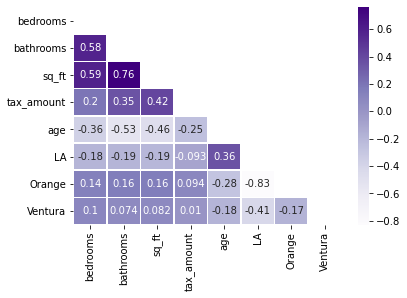

In [28]:
sns.heatmap(train_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(train_corr))

### Make a note of how closely correlated my tax_value and tax_amount are.  I'm of the opinion that this is a little bit of target leakage.  

In [29]:
train.head()

,bedrooms,bathrooms,sq_ft,tax_amount,county,age,LA,Orange,Ventura
537465,3.0,2.5,1971.0,3895.40,Orange,34,0,1,0
554109,4.0,2.0,1878.0,4952.22,LA,62,1,0,0
307369,2.0,2.0,1001.0,2528.27,LA,72,1,0,0
1311281,3.0,2.0,1474.0,1032.70,Orange,66,0,1,0
1755944,3.0,2.0,1221.0,3364.06,LA,70,1,0,0


In [31]:
train.columns

Index(['bedrooms', 'bathrooms', 'sq_ft', 'tax_amount', 'county', 'age', 'LA',
       'Orange', 'Ventura'],
      dtype='object')

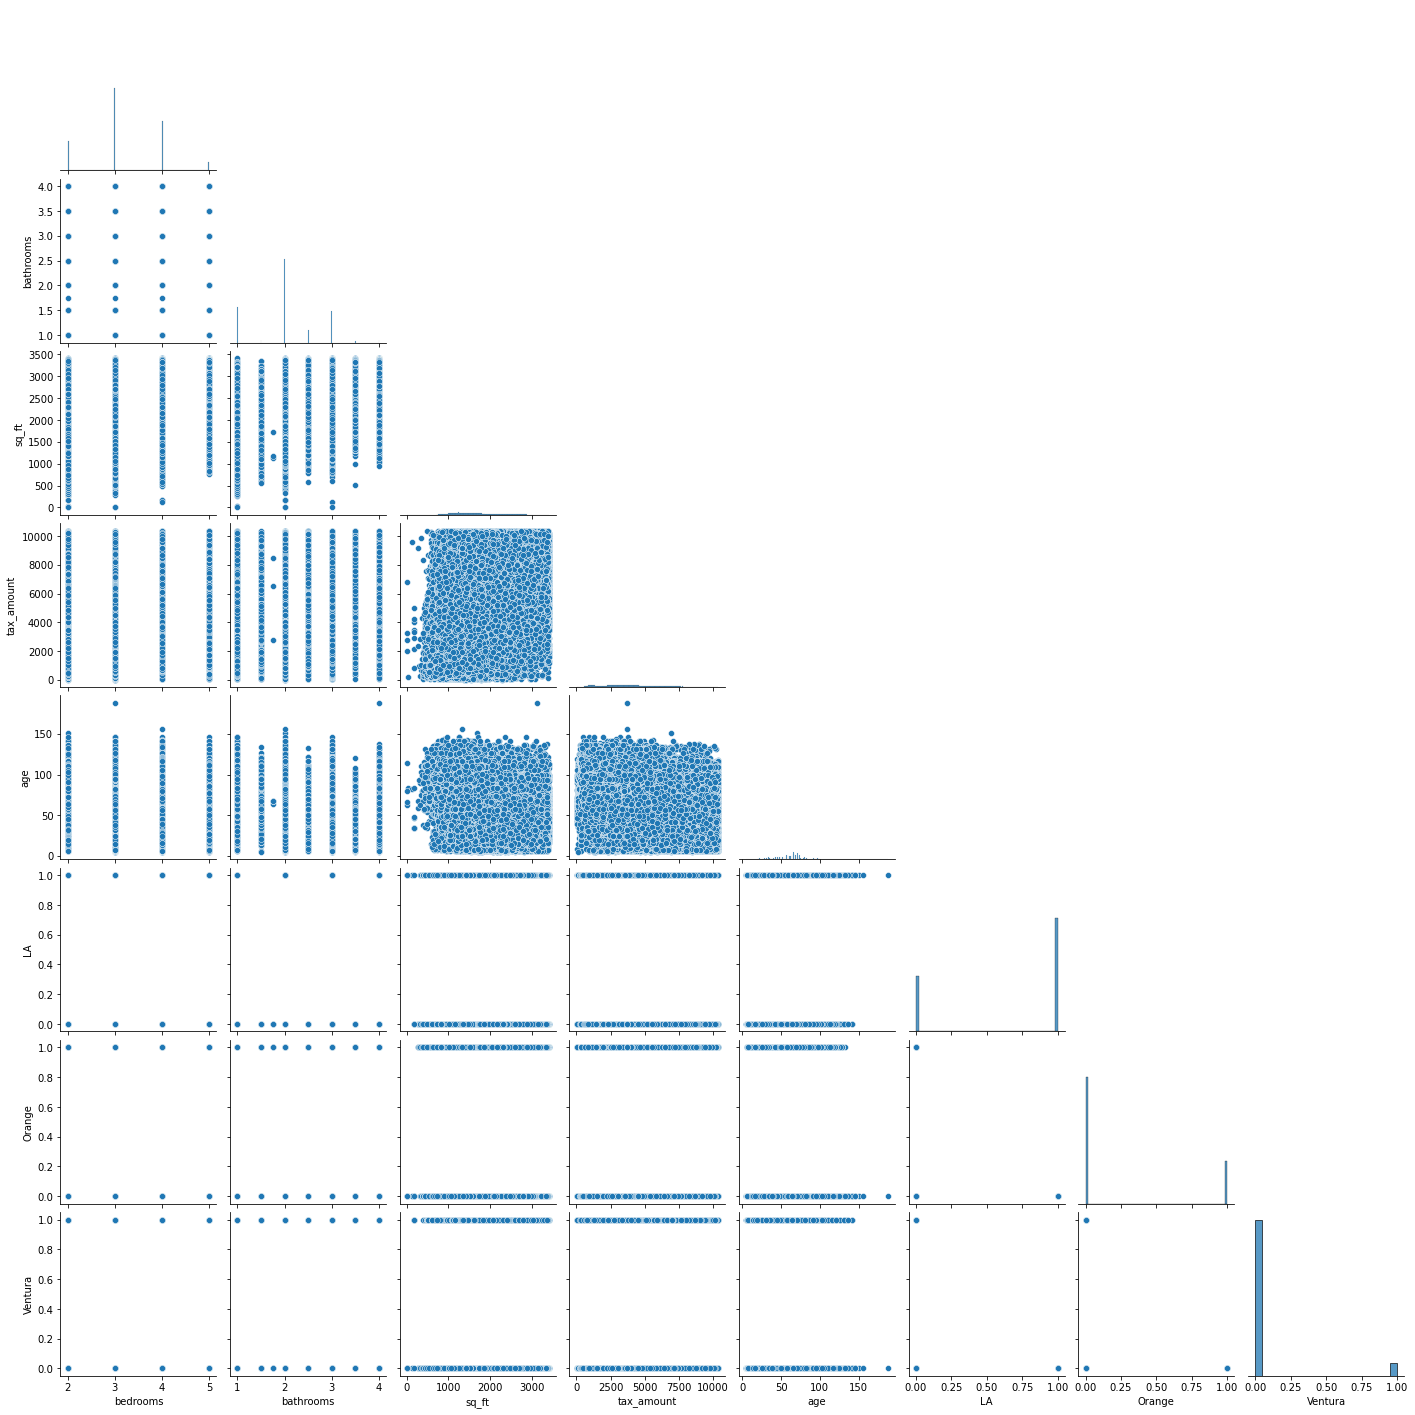

In [32]:
sns.pairplot(data=train,corner=True,)

In [33]:
# I can really pop that line color if I want.

# sns.lmplot(x='age', y="sq_ft", data=zillow, line_kws={'color': 'red'})
# plt.show()

### Newer homes are larger

In [34]:
# This cell will take a long time to run but provide lots of good vizes
# Run it with plenty of time

# var for var in ['sq_ft','tax_value','tax_amount', 'age']:
#     var2 for var2 in ['sq_ft','tax_value','tax_amount', 'age']:
#         plt.figure
#         sns.lmplot(x=var, y=var2)

### Here's a takeaway: bedrooms and bathrooms really are more ordinal than continuous

## Research question number 1: 

Are bigger houses valued higher?

<AxesSubplot:title={'center':'There seems to be a positive correlation between square feet and tax_value'}, xlabel='sq_ft', ylabel='tax_amount'>

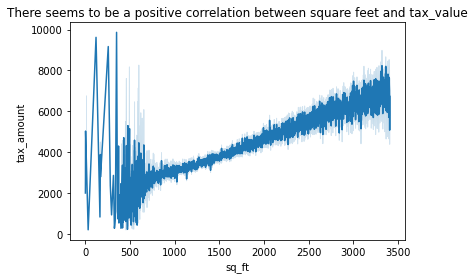

In [41]:
plt.title('There seems to be a positive correlation between square feet and tax_value')

sns.lineplot(x=train.sq_ft, y=train.tax_amount,markers=True)


Hypothesis testing: 

    H_o: Square feet and tax_value are not related
    H_a: Square feet and tax_value are related
    
    The null hypothesis is rejected by the stats test

In [ ]:
alpha = 0.05

corr, p = stats.pearsonr(train.sq_ft, train.tax_value)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
    
corr, p

### There is a moderate correlation between the variables.